In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive



## Import Data


In [ ]:
import pandas as pd
import numpy as np
from timeit import default_timer as timer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

import re
from html.parser import HTMLParser

from sklearn.metrics import classification_report

import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import string

nltk.download('stopwords')
nltk.download('punkt')


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/ML Team 4 0620/WorkOnMergedData/final_merged_data.csv')
df = df.drop('Unnamed: 0', axis=1)

aug_df = pd.read_csv('/content/gdrive/My Drive/ML Team 4 0620/WorkOnMergedData/full_aug_data_v2.csv')
aug_df = aug_df.drop('Unnamed: 0', axis = 1)
uncleaned_df = df.copy(deep=True)

df

,Title,Post Author,Leading Comment,Reply Comments,Category,Forum
0,One item multiple buyers,Stocoloco_LLC,Yesterday I lowered the price of an item to ma...,['Isn’t that what you were trying to do??? Mat...,Fulfillment By Amazon,Amazon
1,Unavailable payment,storesupplies,I got my new credit card and before I could up...,"['You can’t. You just have to wait.', 'You can...",Fulfillment By Amazon,Amazon
2,Some FBA items Not Showing Inventory,ShipFlip,I sent an FBA shipment on November 26. They sh...,['This topic was automatically closed 180 days...,Fulfillment By Amazon,Amazon
3,Stock products,Andean_Star,"Hi, I need to know the products stock in Selle...",['You need to have a professional account and ...,Fulfillment By Amazon,Amazon
4,Frustrating Seller Support for faulty LTSF cat...,Illuminations_Brand,Just here to vent at the Asia based Seller Sup...,['Illuminations_Brand\nIf you’re here in the U...,Fulfillment By Amazon,Amazon
...,...,...,...,...,...,...
8836,Dealing With Idiots1,scottschmitz,Anyone have any creative way to deal with othe...,['Mitch & LizD Might have some insight into th...,Misc Topics,Flowster
8837,Emailing from Hubspot1,VonT,It looks like to me when you or your VAs email...,[],Misc Topics,Flowster
8838,About the Sales Channels & Marketplaces Category1,Trent-Admin,Have questions about sourcing the various sale...,[],eCommerce Marketplaces,Flowster
8839,Storefront Question1,Laura,"If I am posting this in the wrong place, my ap...",['scottschmitz we would be able to do transact...,eCommerce Marketplaces,Flowster


## Data Cleaning

In [ ]:
stop_words = list(set(stopwords.words('english')))
punct = list(set(string.punctuation))
punct.append('“')
punct.append('”')
stemmer = PorterStemmer()

def text_cleaning(text):
    # converting HTML character codes to ASCII code
    #parser = HTMLParser()
    #text =  parser.unescape(text)
    text = str(text)
    text = re.sub(r'<[^>]+>','',text) # removing HTML tags
    text = re.sub(r'(?:\#+[\w_]+[\w\'_\-]*[\w_]+)','',text) # removing hash-tags
    text = re.sub(r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+','',text) # removing URLs
    text = re.sub(r'(?:[\ufffd]+)','',text) #removing special characters
    text = word_tokenize(text)
    text = ' '.join(word for word in text if word not in punct) #remove punctuation
    text = re.sub('\n',' ',text) #remove new line
    text = re.sub('@','',text) #remove @ sign
    text = re.sub('\'','',text) # remove '
    text = text.lower() # lowercase all characters
    text = word_tokenize(text) # tonkenize words
    text = [i for i in text if not i in stop_words] #remove stop words
    #text = [stemmer.stem(word) for word in text]
    text = ' '.join(text)
    
    return text


In [ ]:
df['Title'] = df['Title'].apply(lambda x: text_cleaning(x))
df['Leading Comment'] = df['Leading Comment'].apply(lambda x: text_cleaning(x))
df['Reply Comments'] = df['Reply Comments'].apply(lambda x: text_cleaning(x))

aug_df['texts'] = aug_df['texts'].apply(lambda x: text_cleaning(x))
aug_df['labels'] = aug_df['labels'].apply(lambda x: text_cleaning(x))
#aug_df['Reply Comments'] = aug_df['Reply Comments'].apply(lambda x: text_cleaning(x))



In [ ]:
#Here we combine the leading comment with the reply comments in order to have more words in our model
df['All Comments'] = df['Leading Comment'] + ' '+ df['Reply Comments']
uncleaned_df['All Comments'] = uncleaned_df['Leading Comment'] + ' ' + uncleaned_df['Reply Comments']

## TF-IDF Model

This is the best model tested so far using the replies concatenated with the leading comment.

In [ ]:

#Now we initialize our TF-IDF object, max features are 1000
cvec = TfidfVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 7500,
                         lowercase = True)
#Pull a series object with all the comments from the dataframe into it 
documents = df['Leading Comment'].values.astype('U')
#We set our X dataset for our model to be the output of the CountVectorizer word embedding
X = cvec.fit_transform(documents).toarray()
words = cvec.get_feature_names()
# We get the labels for our model as the categories for all the links
y = df['Category']

#Here we split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle = True)
start = timer();
logisticReg = LogisticRegression(max_iter=500)
logisticReg.fit(X_train, y_train)

y_pred = logisticReg.predict(X_test)
result = classification_report(y_test, y_pred)
print(result)
end= timer();


score = logisticReg.score(X_test, y_test)
print("Score for our model "+str(score))
print("Time for model " + str(end-start))

                                                    precision    recall  f1-score   support

                                    Account Health       0.79      0.86      0.83       296
                                     Amazon Custom       0.82      0.23      0.36        61
              Amazon Marketplace Web Service (MWS)       0.80      0.53      0.64        70
                                        Amazon Pay       0.80      0.62      0.70       129
                                   Amazon Specific       0.00      0.00      0.00         8
                         Amazon Sponsored Products       0.91      0.64      0.75        61
                              Financial Management       0.00      0.00      0.00         1
                                 Flowster-specific       0.67      0.15      0.25        13
                                       Fulfillment       0.00      0.00      0.00         3
                             Fulfillment By Amazon       0.72      0.75      0.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Attempted Hypertuning on C with cross validation of the model


In [ ]:
#Now we initialize our TF-IDF object, max features are 1000
cvec = TfidfVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 7500,
                         lowercase = True)
#Pull a series object with all the comments from the dataframe into it 
documents = df['Leading Comment'].values.astype('U')
#We set our X dataset for our model to be the output of the CountVectorizer word embedding
X = cvec.fit_transform(documents).toarray()
words = cvec.get_feature_names()
# We get the labels for our model as the categories for all the links
y = df['Category']

#Here we split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle = True)
logReg = LogisticRegression()

param_grid = [    
    {
    'C' : np.logspace(-4, 4, 2),
     'max_iter' : [100, 250, 500]
    }
]

clf = GridSearchCV(logReg, param_grid=param_grid, cv = 3, verbose = True, n_jobs= 1)

start = timer();
best_clf = clf.fit(X_train, y_train);

#logisticReg.fit(X_train, y_train)
#y_pred = logisticReg.predict(X_test)
#result = classification_report(y_test, y_pred)
#print(result)

#best_clf.best_estimator_
end = timer();
print("Total time elapsed: " +str(end-start))

#score = logisticReg.score(X_test, y_test)
#print("Score for our model "+str(score))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED

Total time elapsed: 841.06001371


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'C': 10000.0, 'max_iter': 100}
Accuracy - : 0.914
LogisticRegression(C=10000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
                                                    precision    recall  f1-score   support

                                    Account Health       0.73      0.78      0.76       312
                                     Amazon Custom       0.60      0.33      0.43        63
              Amazon Marketplace Web Service (MWS)       0.70      0.55      0.62        67
                                        Amazon Pay       0.54      0.59      0.56       111
                                   Amazon Specific       0.33      0.12      0.18         8
                         Amazon Sponsored Products       0.74     

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


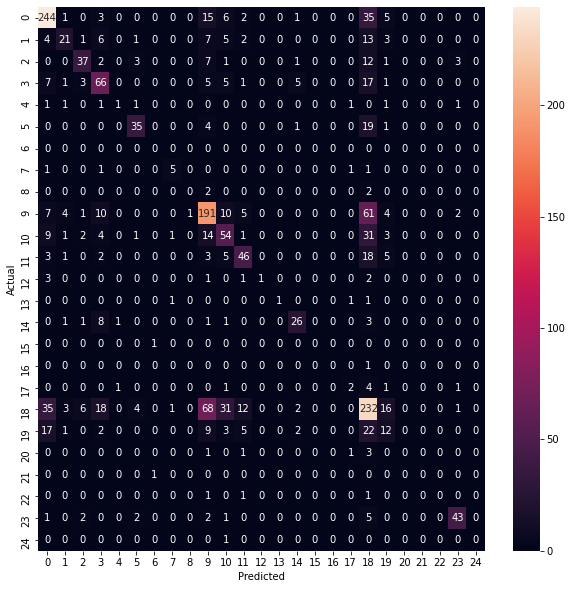

In [ ]:
print(best_clf.best_params_)
print (f'Accuracy - : {best_clf.score(X,y):.3f}')
print(best_clf.best_estimator_)
y_true, y_pred = y_test, best_clf.predict(X_test)
print(classification_report(y_true, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
        xticklabels="auto", yticklabels="auto")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Running on the Augmented DataSet

In [ ]:
#Now we initialize our TF-IDF object, max features are 1000
cvec = TfidfVectorizer(analyzer = 'word',
                         stop_words = 'english',
                         max_features = 7500,
                         lowercase = True)
#Pull a series object with all the comments from the dataframe into it 
documents = aug_df['texts'].values.astype('U')
#We set our X dataset for our model to be the output of the CountVectorizer word embedding
X = cvec.fit_transform(documents).toarray()
words = cvec.get_feature_names()
# We get the labels for our model as the categories for all the links
y = aug_df['labels']

#Here we split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    shuffle = True)
logReg = LogisticRegression()

param_grid = [    
    {
    'C' : np.logspace(-4, 4, 2),
     'max_iter' : [100, 250, 500]
    }
]

clf = GridSearchCV(logReg, param_grid=param_grid, cv = 3, verbose = True, n_jobs= 1)

start = timer();
best_clf = clf.fit(X_train, y_train);

#logisticReg.fit(X_train, y_train)
#y_pred = logisticReg.predict(X_test)
#result = classification_report(y_test, y_pred)
#print(result)

#best_clf.best_estimator_
end = timer();
print("Total time elapsed: " +str(end-start))

#score = logisticReg.score(X_test, y_test)
#print("Score for our model "+str(score))

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
 

Total time elapsed: 1836.4366555960005


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


{'C': 10000.0, 'max_iter': 100}
Accuracy - : 0.863
LogisticRegression(C=10000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
                                                    precision    recall  f1-score   support

                                    Account Health       0.78      0.82      0.80       612
                                     Amazon Custom       0.65      0.52      0.58       123
              Amazon Marketplace Web Service (MWS)       0.78      0.55      0.64       110
                                        Amazon Pay       0.56      0.44      0.49       240
                                   Amazon Specific       0.93      0.96      0.95       223
                         Amazon Sponsored Products       0.44     

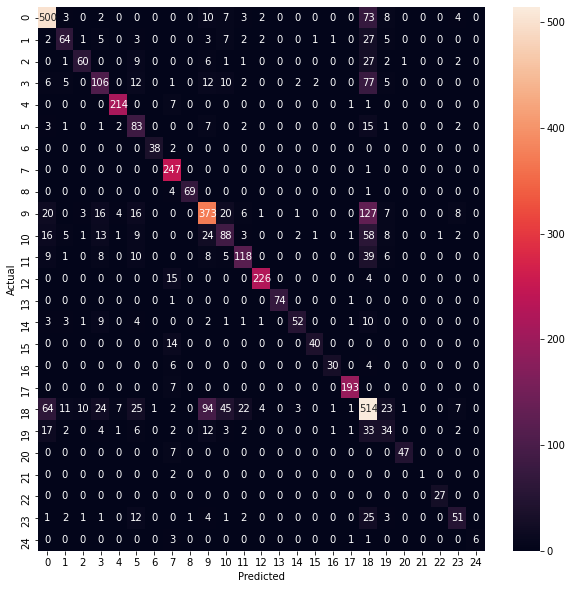

In [ ]:
print(best_clf.best_params_)
print (f'Accuracy - : {best_clf.score(X,y):.3f}')
print(best_clf.best_estimator_)
y_true, y_pred = y_test, best_clf.predict(X_test)
print(classification_report(y_true, y_pred))

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
        xticklabels="auto", yticklabels="auto")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()